In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from PIL import Image
from google.colab import drive
from tqdm import tqdm
import itertools
from numba import jit
import numpy.typing as npt
import scipy as scp

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
indices = np.arange(-4, 5)
neighbours = itertools.product(indices, repeat=2)
directions = [*neighbours]
directions.remove((0,0))

In [95]:
def adjacency_matrix(image, sigma_intensity=1000, sigma_space=10):
  image_pixels = np.array(image, dtype=np.float64)
  shape_rows, shape_cols, _ = image_pixels.shape
  W = scipy.sparse.lil_matrix((shape_rows * shape_cols, shape_rows * shape_cols), dtype = np.float64)

  directions = [(-4, -4), (-4, -3), (-4, -2), (-4, -1), (-4, 0), (-4, 1), (-4, 2), (-4, 3), (-4, 4),
                (-3, -4), (-3, -3), (-3, -2), (-3, -1), (-3, 0), (-3, 1), (-3, 2), (-3, 3), (-3, 4),
                (-2, -4), (-2, -3), (-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2), (-2, 3), (-2, 4),
                (-1, -4), (-1, -3), (-1, -2), (-1, -1), (-1, 0), (-1, 1), (-1, 2), (-1, 3), (-1, 4),
                (0, -4), (0, -3), (0, -2), (0, -1), (0, 1), (0, 2), (0, 3), (0, 4),
                (1, -4), (1, -3), (1, -2), (1, -1), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4),
                (2, -4), (2, -3), (2, -2), (2, -1), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
                (3, -4), (3, -3), (3, -2), (3, -1), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4),
                (4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]

  for i in tqdm(range(shape_rows)):
    for j in range(shape_cols):
      for dx, dy in directions:
        xx, yy = i + dx, j + dy
        if 0 <= xx < shape_rows and 0 <= yy < shape_cols:
          k = i * shape_cols + j
          l = xx * shape_cols + yy
          distance_rgb = np.linalg.norm((image_pixels[i, j] - image_pixels[xx, yy])) ** 2
          distance_space = (i-xx) ** 2 + (j-yy) ** 2
          W[k, l] = np.exp(- distance_space / sigma_space) * np.exp(- distance_rgb / sigma_intensity)

          if W[k, l] < 1e-14:
            W[k, l] = 0

  return W

In [73]:
def laplacian_eigenmaps(adjacency, n):
  L, D = scipy.sparse.csgraph.laplacian(adjacency, return_diag=True)
  L *= -1
  L += scipy.sparse.eye(*L.shape)
  eigenvals, eigenvecs = scipy.sparse.linalg.eigsh(L, k = n + 1, sigma=1.0, which='LM')

  # drop the zero eigenvalue and constant eigenvector
  eigenvals = eigenvals[:-1]
  eigenvecs = eigenvecs[:, :-1]

  eigenvals = 1 - eigenvals
  eigenvecs = eigenvecs / D[:, None]

  return eigenvals, eigenvecs

In [74]:
def hyperbolic_laplacian(g_adj_matrix, alpha_arr=None, symmetrize=False):
    """Create a hyperbolic Laplacian matrix for a given adjacency matrix
        and alpha vector.

    If the `alpha_arr` that tracks the connections of our artificial node
    is not given, it is assumed that all alphas are equal, and the vector
    is normalized.

    We symmetrize the g_adj_matrix if the corresponding flag is given
    (and by default).
    Note that this just means adding its conjugate transpose, which
    will corrupt the weights if they are partially symmetrized already
    or double them if they are fully symmetrized.

    :param g_adj_matrix: Sparse adjacency matrix of the graph.
    :param alpha_arr: Vector of alpha values, if present.
    :param symmetrize: Whether to symmetrize the adjacency matrix
    :return: Sparse hyperbolic Laplacian matrix.
    """

    if alpha_arr is None:
        alpha_arr = np.full(
            g_adj_matrix.shape[0], 1./g_adj_matrix.shape[0])

    hyp_lap_of_g_shape = (g_adj_matrix.shape[0]+1, g_adj_matrix.shape[0]+1)

    laplacian = scp.sparse.csgraph.laplacian(
        g_adj_matrix, symmetrized=symmetrize).tocsr()
    hyp_lap_of_g = laplacian

    # Now we make the diagonal equal the standard Laplacian diag
    # minus alpha_arr:
    hyp_lap_of_g = (hyp_lap_of_g
                    - scp.sparse.diags(alpha_arr, offsets=0, format='csr'))

    top = scp.sparse.hstack(
        (scp.sparse.csr_matrix([[-np.add.reduce(alpha_arr)]]),
         scp.sparse.csr_matrix(alpha_arr)))
    bottom_rows = scp.sparse.hstack(
        (scp.sparse.csr_matrix(alpha_arr).T,
         hyp_lap_of_g), format='csr')

    return scp.sparse.vstack((top, bottom_rows), format='csr')

In [9]:
def hyp_laplacian_eigenmaps(adjacency, n):
  L = hyperbolic_laplacian(adjacency)
  L *= -1
  L += scipy.sparse.eye(*L.shape)
  eigenvals, eigenvecs = scipy.sparse.linalg.eigsh(L, k = n + 1, sigma=1.0, which='LM')

  eigenvals = eigenvals[:-1]
  eigenvecs = eigenvecs[:, :-1]

  eigenvals = 1 - eigenvals
  eigenvecs = eigenvecs

  return eigenvals, eigenvecs

In [10]:
def segmentation(image, eigenvec):
  image_seg = np.array(image)
  for i in range(image_seg.shape[0]):
      for j in range(image_seg.shape[1]):
          if eigenvec[(i * image_seg.shape[1] + j)] > 0:
              image_seg[i][j] = [255,255,255]
  return image_seg

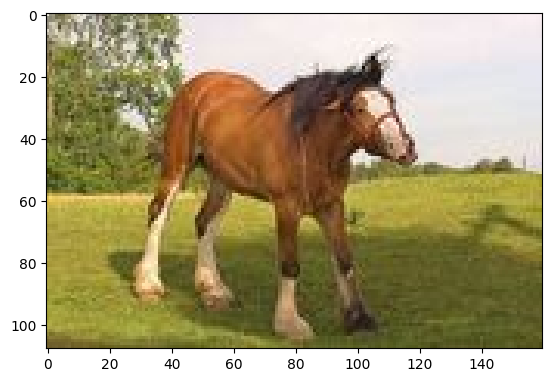

In [80]:
horse = np.array(Image.open('/content/drive/My Drive/pictures/horse.jpg'))
plt.imshow(horse)

In [81]:
picture1 = np.array(horse)
W1 = adjacency_matrix(picture1)

100%|██████████| 108/108 [00:23<00:00,  4.55it/s]


In [82]:
lam1, vecs1 = laplacian_eigenmaps(W1, 6)

lam_hyp1, vecs_hyp1 = hyp_laplacian_eigenmaps(W1, 6)

print(lam1)
print(lam_hyp1)

[0.01950078 0.01658205 0.010692   0.00888634 0.00607696 0.0022525 ]
[0.01944291 0.01652418 0.01063413 0.00882847 0.00601909 0.00219463]


Text(0.5, 1.0, 'Hyperbolic segmentation')

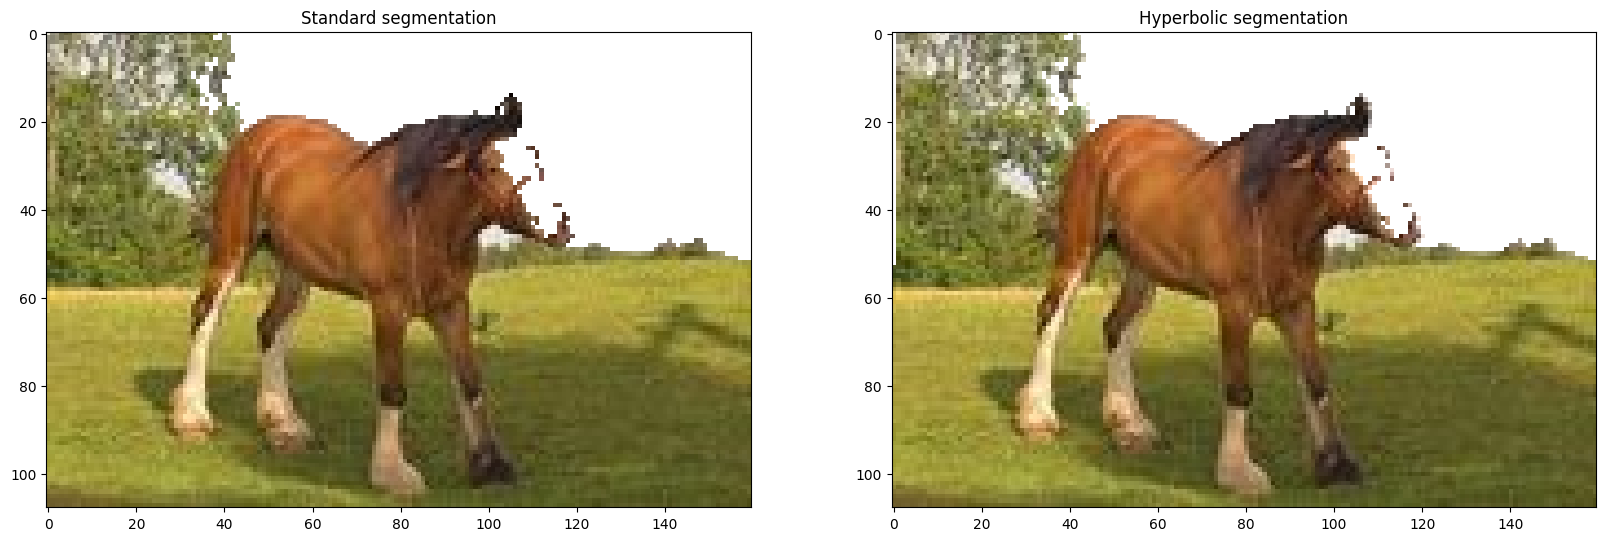

In [85]:
picture1_seg = segmentation(picture1, vecs1[:,-1])
picture1_seg_hyp = segmentation(picture1, vecs_hyp1[:,-1])
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(picture1_seg)
ax[1].imshow(picture1_seg_hyp)

ax[0].set_title("Standard segmentation")
ax[1].set_title("Hyperbolic segmentation")

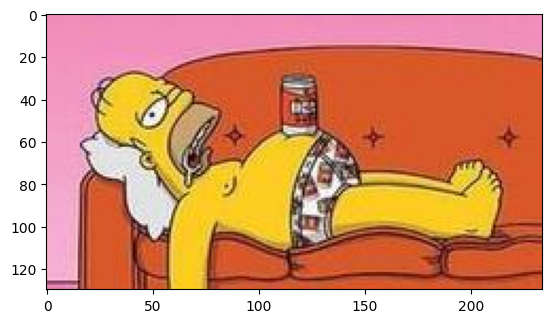

In [59]:
homer = np.array(Image.open('/content/drive/My Drive/pictures/homer.jpg'))
plt.imshow(homer)

In [60]:
picture2 = np.array(homer)
W2 = adjacency_matrix(picture2)

100%|██████████| 130/130 [01:06<00:00,  1.96it/s]


In [61]:
lam2, vecs2 = laplacian_eigenmaps(W2, 6)

lam_hyp2, vecs_hyp2 = hyp_laplacian_eigenmaps(W2, 6)

print(lam2)
print(lam_hyp2)

[3.61799590e-05 3.11329577e-05 3.05025037e-05 2.47952891e-05
 1.39909036e-05 5.73745578e-07]
[ 2.73924552e-05  3.30684935e-06  7.77156117e-16 -1.74015257e-06
 -2.37060461e-06 -8.07782572e-06]


Text(0.5, 1.0, 'Hyperbolic segmentation')

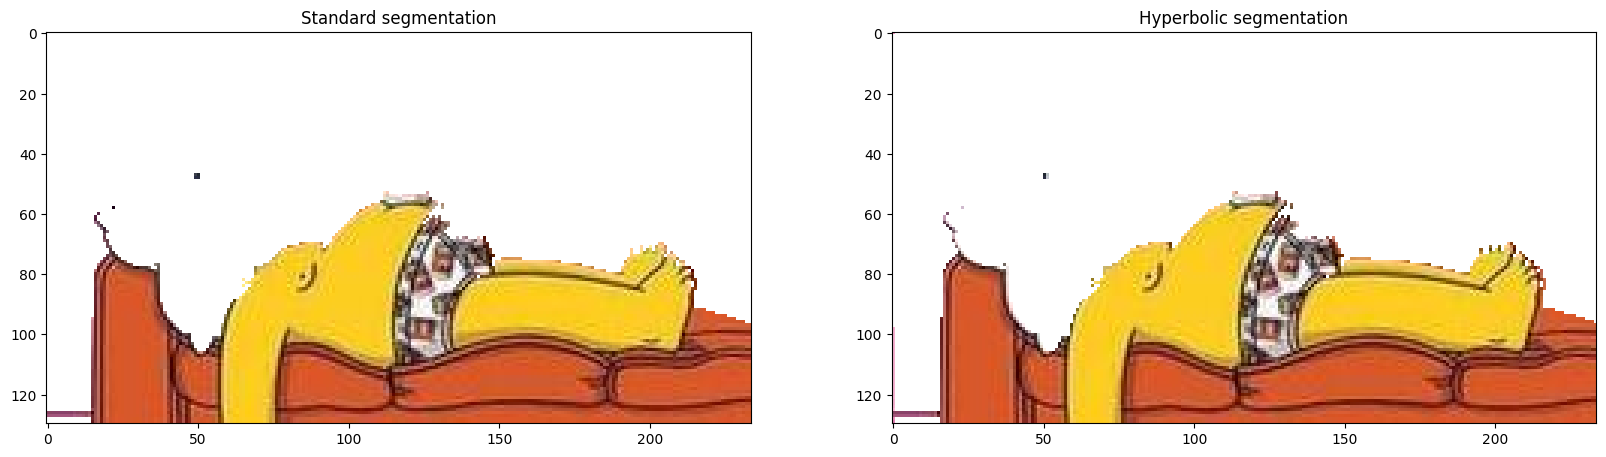

In [78]:
picture2_seg = segmentation(picture2, vecs2[:,-6])
picture2_seg_hyp = segmentation(picture2, vecs_hyp2[:,-5])
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(picture2_seg)
ax[1].imshow(picture2_seg_hyp)

ax[0].set_title("Standard segmentation")
ax[1].set_title("Hyperbolic segmentation")

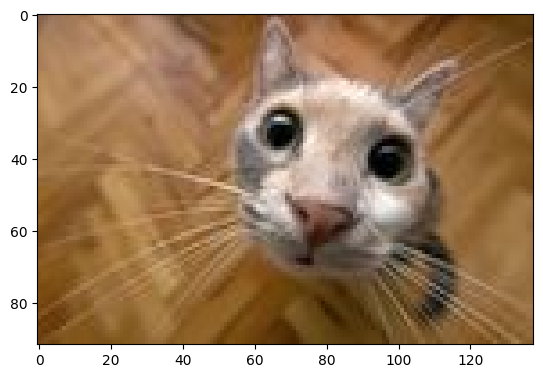

In [116]:
cat1 = np.array(Image.open('/content/drive/My Drive/pictures/cat2.jpg'))
plt.imshow(cat1)

In [126]:
picture3 = np.array(cat1)
W3 = adjacency_matrix(picture3)

100%|██████████| 92/92 [00:18<00:00,  4.87it/s]


In [127]:
lam3, vecs3 = laplacian_eigenmaps(W3, 6)

lam_hyp3, vecs_hyp3 = hyp_laplacian_eigenmaps(W3, 6)

print(lam3)
print(lam_hyp3)

[0.00665197 0.00341737 0.00327256 0.00312186 0.00273743 0.00223654]
[0.00657321 0.00333861 0.00319379 0.0030431  0.00265866 0.00215778]


Text(0.5, 1.0, 'Hyperbolic segmentation')

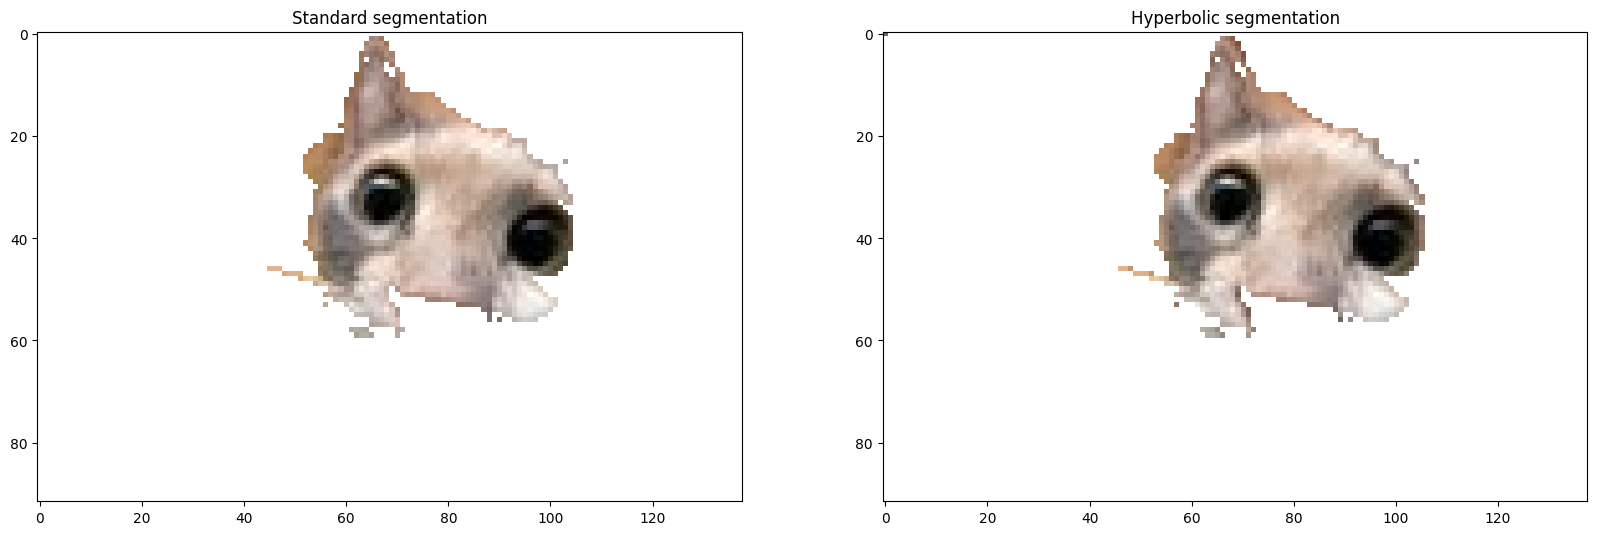

In [135]:
picture3_seg = segmentation(picture3, vecs3[:,-2])
picture3_seg_hyp = segmentation(picture3, vecs_hyp3[:,-2])
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(picture3_seg)
ax[1].imshow(picture3_seg_hyp)

ax[0].set_title("Standard segmentation")
ax[1].set_title("Hyperbolic segmentation")

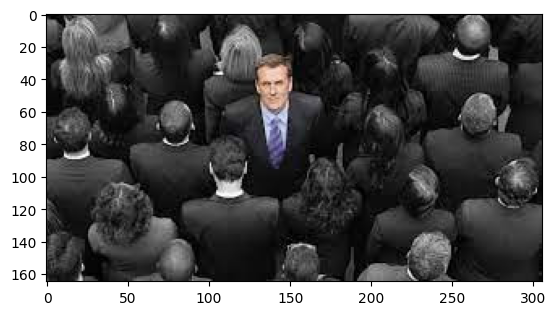

In [81]:
crowd1 = np.array(Image.open('/content/drive/My Drive/pictures/crowd1.jpg'))
plt.imshow(crowd1)

In [82]:
picture4 = np.array(crowd1)
W4 = adjacency_matrix(picture4)

100%|██████████| 165/165 [01:23<00:00,  1.97it/s]


In [ ]:
lam4, vecs4 = laplacian_eigenmaps(W4, 6)

lam_hyp4, vecs_hyp4 = hyp_laplacian_eigenmaps(W4, 6)

print(lam4)
print(lam_hyp4)

Text(0.5, 1.0, 'Hyperbolic segmentation')

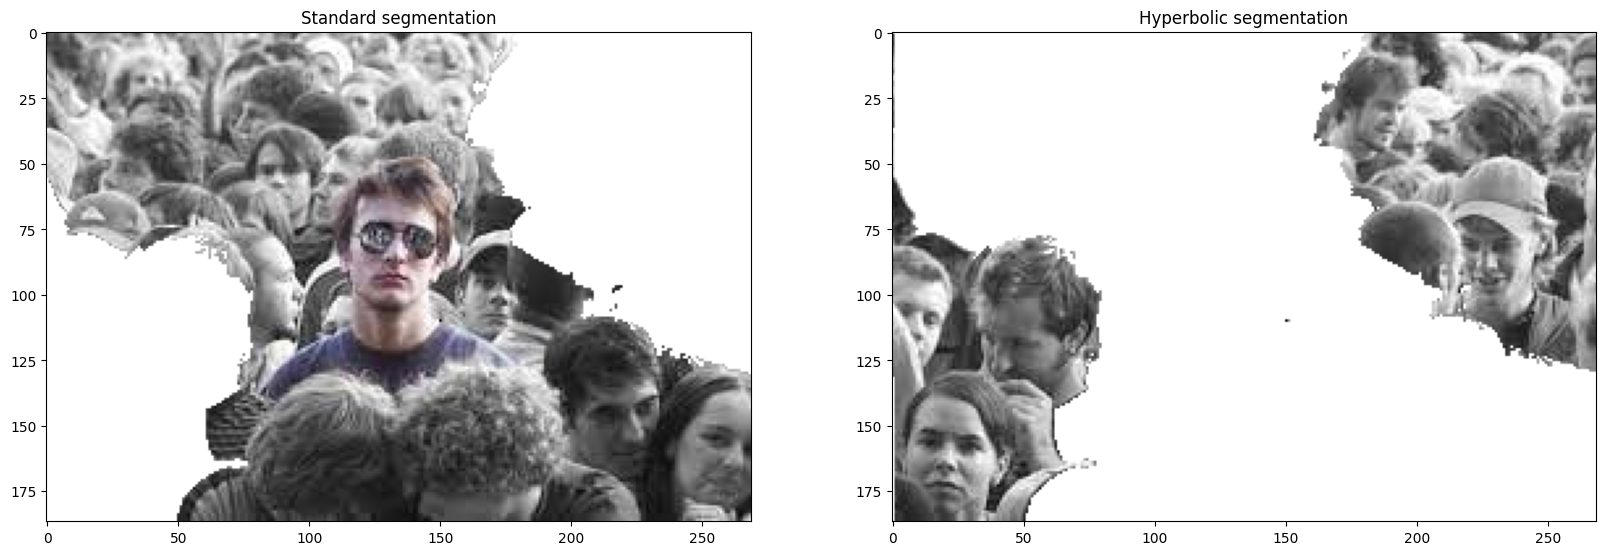

In [154]:
picture4_seg = segmentation(picture4, vecs4[:,-6])
picture4_seg_hyp = segmentation(picture4, vecs_hyp4[:,-6])
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(picture4_seg)
ax[1].imshow(picture4_seg_hyp)

ax[0].set_title("Standard segmentation")
ax[1].set_title("Hyperbolic segmentation")

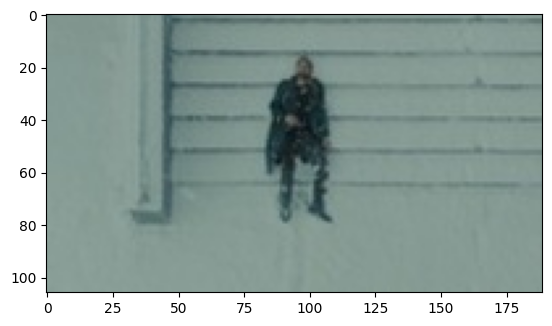

In [11]:
gosling = np.array(Image.open('/content/drive/My Drive/pictures/rayan.jpg'))
plt.imshow(gosling)

In [12]:
picture5 = np.array(gosling)
W5 = adjacency_matrix(picture5)

100%|██████████| 106/106 [00:35<00:00,  3.01it/s]


In [13]:
lam5, vecs5 = laplacian_eigenmaps(W5, 6)

lam_hyp5, vecs_hyp5 = hyp_laplacian_eigenmaps(W5, 6)

print(lam5)
print(lam_hyp5)

[0.05317524 0.03533141 0.02040707 0.01345785 0.00857875 0.0047398 ]
[0.05312532 0.0352815  0.02035715 0.01340794 0.00852884 0.00468988]


Text(0.5, 1.0, 'Hyperbolic segmentation')

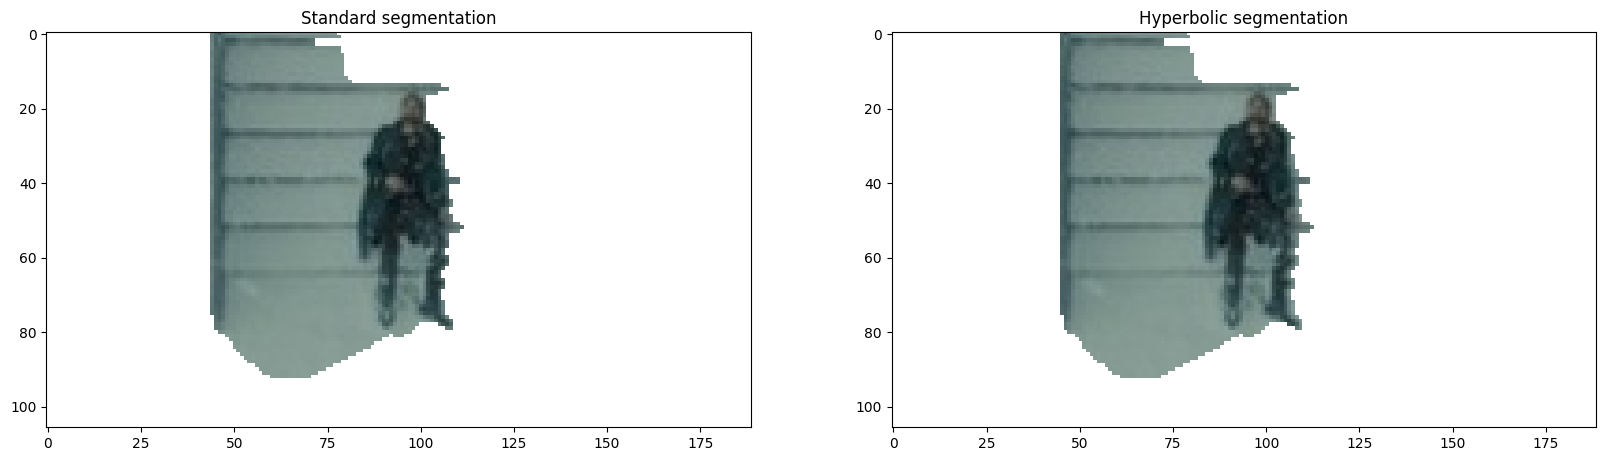

In [20]:
picture5_seg = segmentation(picture5, vecs5[:,-2])
picture5_seg_hyp = segmentation(picture5, vecs_hyp5[:,-2])
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(picture5_seg)
ax[1].imshow(picture5_seg_hyp)

ax[0].set_title("Standard segmentation")
ax[1].set_title("Hyperbolic segmentation")

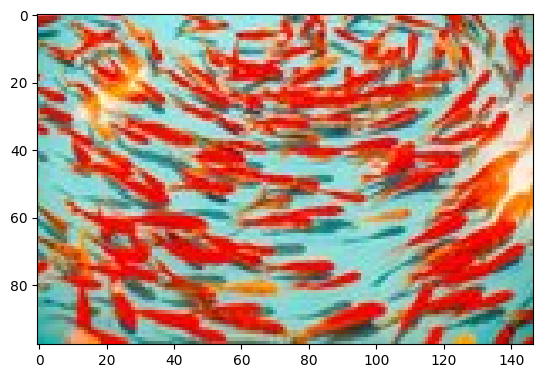

In [21]:
fish = np.array(Image.open('/content/drive/My Drive/pictures/fish.jpg'))
plt.imshow(fish)

In [47]:
picture6 = np.array(fish)
W6 = adjacency_matrix(picture6)

100%|██████████| 98/98 [00:20<00:00,  4.85it/s]


In [48]:
lam6, vecs6 = laplacian_eigenmaps(W6, 6)

lam_hyp6, vecs_hyp6 = hyp_laplacian_eigenmaps(W6, 6)

print(lam6)
print(lam_hyp6)

[0.00838485 0.00646842 0.0060951  0.00382139 0.0018598  0.00164867]
[0.00831543 0.00639901 0.00602568 0.00375197 0.00179039 0.00157926]


Text(0.5, 1.0, 'Hyperbolic segmentation')

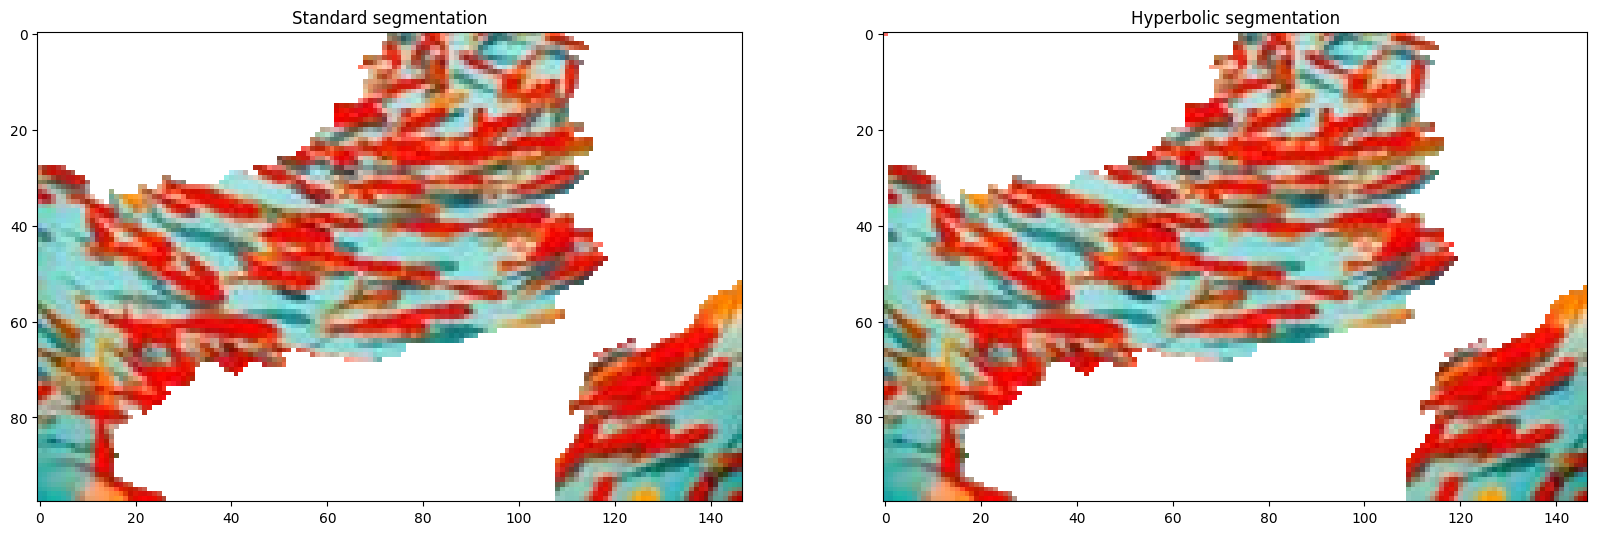

In [56]:
picture6_seg = segmentation(picture6, -vecs6[:,-6])
picture6_seg_hyp = segmentation(picture6, -vecs_hyp6[:,-6])
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(picture6_seg)
ax[1].imshow(picture6_seg_hyp)

ax[0].set_title("Standard segmentation")
ax[1].set_title("Hyperbolic segmentation")

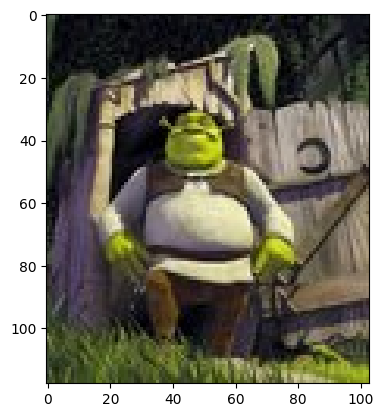

In [57]:
shrek = np.array(Image.open('/content/drive/My Drive/pictures/shrek.jpg'))
plt.imshow(shrek)

In [58]:
picture7 = np.array(shrek)
W7 = adjacency_matrix(picture7)

100%|██████████| 118/118 [00:28<00:00,  4.11it/s]


In [59]:
lam7, vecs7 = laplacian_eigenmaps(W7, 6)

lam_hyp7, vecs_hyp7 = hyp_laplacian_eigenmaps(W7, 6)

print(lam7)
print(lam_hyp7)

[0.02080873 0.01663714 0.01314818 0.01179747 0.00606739 0.00429573]
[0.02072645 0.01655486 0.0130659  0.01171519 0.00598512 0.00421345]


Text(0.5, 1.0, 'Hyperbolic segmentation')

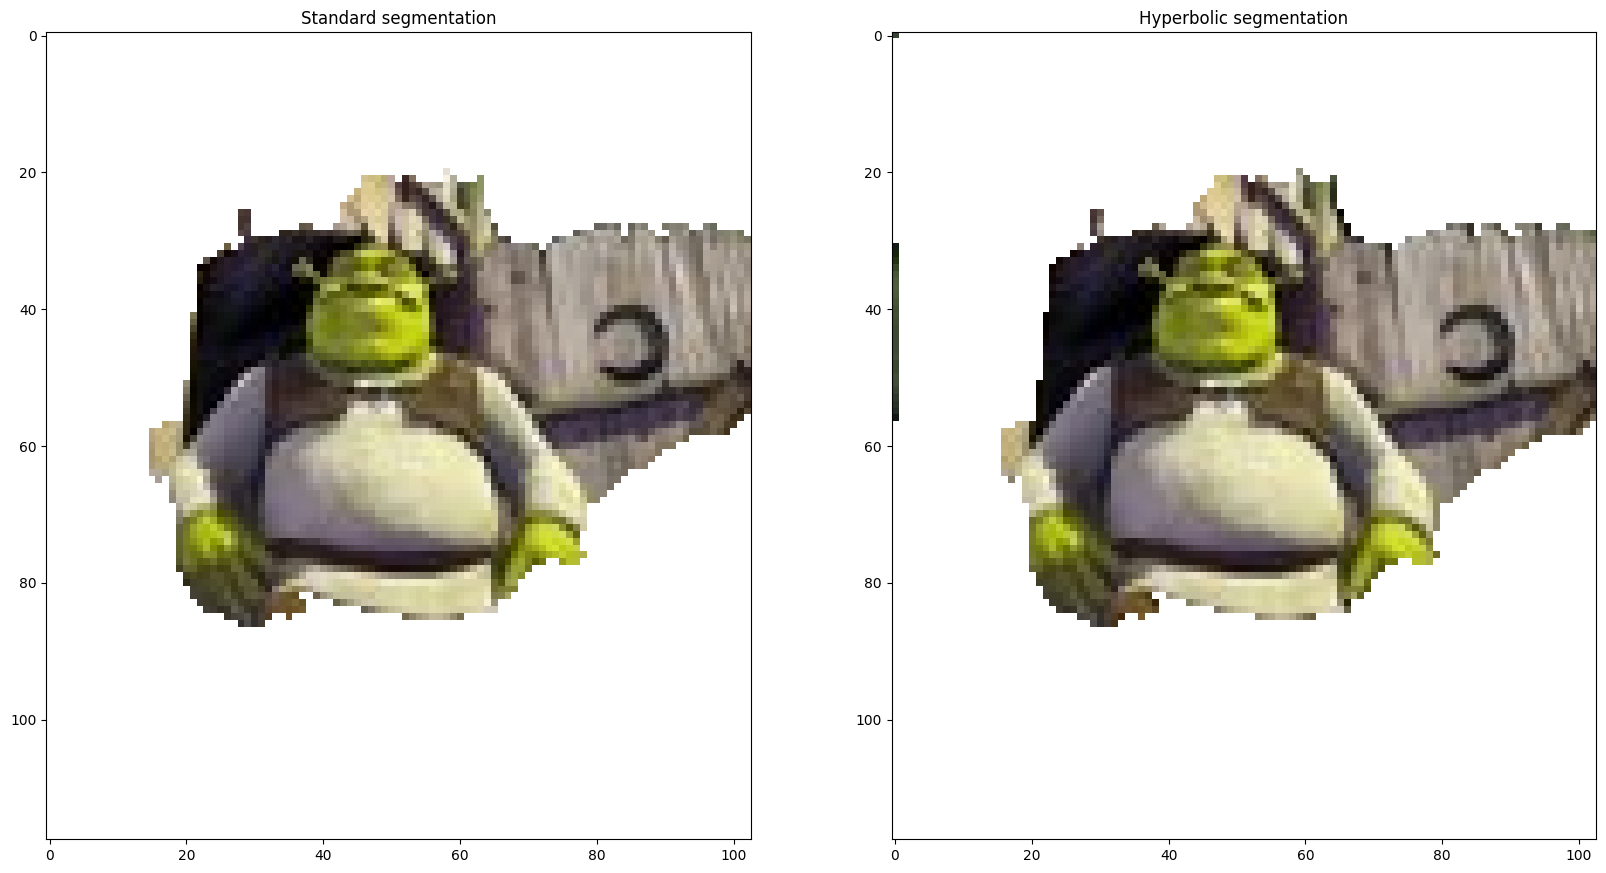

In [70]:
picture7_seg = segmentation(picture7, vecs7[:,-3])
picture7_seg_hyp = segmentation(picture7, vecs_hyp7[:,-3])
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(picture7_seg)
ax[1].imshow(picture7_seg_hyp)

ax[0].set_title("Standard segmentation")
ax[1].set_title("Hyperbolic segmentation")

In [93]:
xor = picture7_seg - picture7_seg_hyp
xor = np.array(xor)

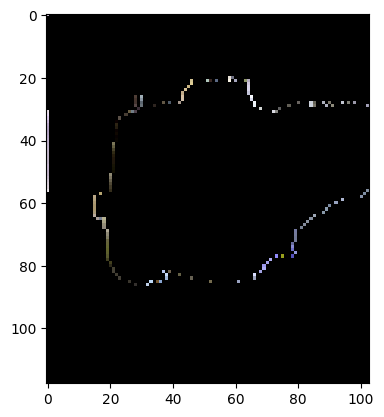

In [94]:
plt.imshow(xor)
